In [85]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Ejercicio

## 🧪 Ejercicio práctico: Predicción de ventas con series de tiempo

### Descripción del dataset

Trabajaremos con un conjunto de datos simulado que cubre **10 años (2010-2019)**. Cada fila representa la cantidad de unidades vendidas de un producto específico en una tienda, en una fecha determinada. El objetivo es **predecir la cantidad vendida (`number_sold`) para el año 2019** utilizando la información de los años anteriores.

Los archivos son:

- `train.csv`: contiene datos desde 2010 hasta 2018.
- `test.csv`: contiene datos del año 2019.

El dataset incluye las siguientes columnas:

- `date`: fecha de la transacción.
- `number_sold`: número de unidades vendidas (variable objetivo).

✅ **No hay valores nulos.**

---

### 🎯 Objetivo del ejercicio

Realizar un análisis completo y desarrollar modelos para predecir la variable `number_sold` en el archivo `test.csv`.

---

### 🧹 Parte 1: Limpieza de datos

- Cargar los datos desde los archivos CSV.
- Verificar los tipos de datos y convertir la columna `date` al formato de fecha.
- Asegurarse de que no haya valores duplicados o errores de formato.

---

### 📊 Parte 2: Análisis exploratorio de datos (EDA)

- Visualizar la evolución de las ventas en el tiempo por tienda y producto.
- Analizar patrones estacionales o tendencias.
- Explorar estadísticas generales: máximos, mínimos, promedios, etc.

---

### 📈 Parte 3: Modelamiento estadístico de series de tiempo

Selecciona una combinación específica de tienda y producto (por ejemplo: `store = 1`, `product = 5`) y realiza:

- **Descomposición de la serie de tiempo** en tendencia, estacionalidad y ruido.
- Análisis de **ACF (Autocorrelation Function)** y **PACF (Partial ACF)**.
- Selección de un modelo adecuado (por ejemplo, ARIMA o SARIMA).
- Evaluación de resultados:
  - Gráficamente.
  - Usando la métrica **MAPE (Mean Absolute Percentage Error)**.

---

### 🤖 Parte 4: Modelamiento supervisado

- Crear un dataset con variables predictoras (`features`) usando técnicas como:
  - Lag features (valores anteriores de la serie).
  - Rolling mean o media móvil.
  - Variables temporales (mes, día, día de la semana, etc.).
- Definir la variable objetivo (`target`) como `number_sold`.
- Entrenar un modelo de **Random Forest Regressor** para predecir las ventas.
- Evaluar el rendimiento:
  - Gráficamente (comparar predicción vs. real).
  - Usando **MAPE**.

---

### 📌 Nota

Este ejercicio permite comparar dos enfoques para abordar series de tiempo:
1. Enfoque estadístico clásico.
2. Enfoque supervisado con ingeniería de variables.

---


## Limpieza de Datos

In [86]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [87]:
# Convertimos las columnas 'Date' en pd.datetime
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

# Establecemos la columna de fecha como indice
df_train.set_index('Date', inplace=True)
df_test.set_index('Date', inplace=True)

# Resamplear los datos a frecuencia mensual (sumando el total de ventas por mes)
monthly_train = df_train['number_sold'].resample('ME').sum()
monthly_test = df_test['number_sold'].resample('ME').sum()

## EDA

In [88]:
print(f'Hay {monthly_train.isna().sum()} valores faltantes en monthly_train')
print(f'Hay {monthly_test.isna().sum()} valores faltantes en monthly_test\n')
print(f'Hay {monthly_train.duplicated().sum()} valores duplicados en monthly_test')
print(f'Hay {monthly_test.duplicated().sum()} valores duplicados en monthly_test')

Hay 0 valores faltantes en monthly_train
Hay 0 valores faltantes en monthly_test

Hay 1 valores duplicados en monthly_test
Hay 0 valores duplicados en monthly_test


Hay que buscar si es por que se repitio el valor o si es por que se repitio el mes y el valor.

In [112]:
#Veamos si el vbalor esta duplicado a nivel de mes
monthly_train.index.value_counts().sort_values()

Date
2010-01-31    1
2010-04-30    1
2010-05-31    1
2010-06-30    1
2010-07-31    1
             ..
2018-11-30    1
2016-12-31    1
2016-11-30    1
2018-02-28    1
2018-12-31    1
Name: count, Length: 108, dtype: int64

In [89]:
# Drop a mi valor duplicado
monthly_train = monthly_train.drop_duplicates()

In [ ]:
# Reindex para ver que no tengamos valores faltantes en fechas
fecha_completa = pd.date_range(start=monthly_train.index.min(), end=monthly_train.index.max(), freq='ME')
monthly_train = monthly_train.reindex(fecha_completa)

fecha_completa = pd.date_range(start=monthly_test.index.min(), end=monthly_train.index.max(), freq='ME')
monthly_train = monthly_train.reindex(fecha_completa)

<Axes: xlabel='Date'>

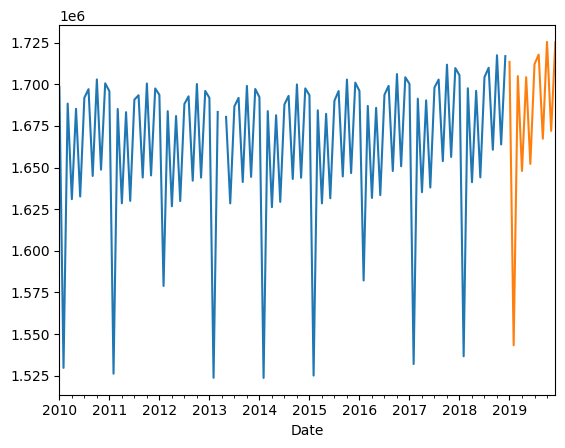

In [91]:
monthly_train.plot()
monthly_test.plot()

## Modelamiento Estadistico

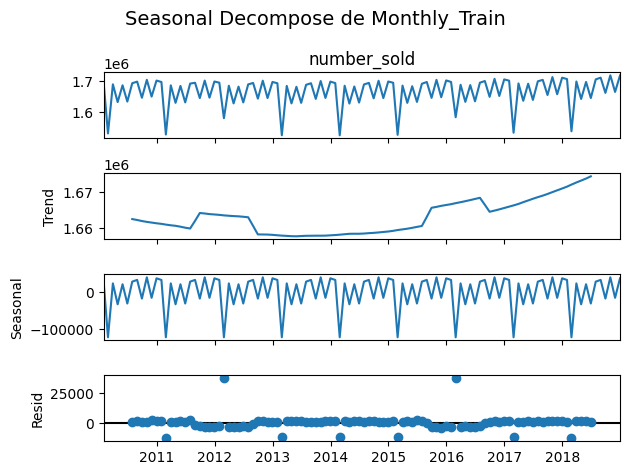

In [126]:
# Seasonal Decompose Train
train_seasonal = seasonal_decompose(monthly_train, model='additive', period=12)
train_seasonal.plot()
plt.suptitle('Seasonal Decompose de Monthly_Train', fontsize=14)
plt.tight_layout()
plt.show()

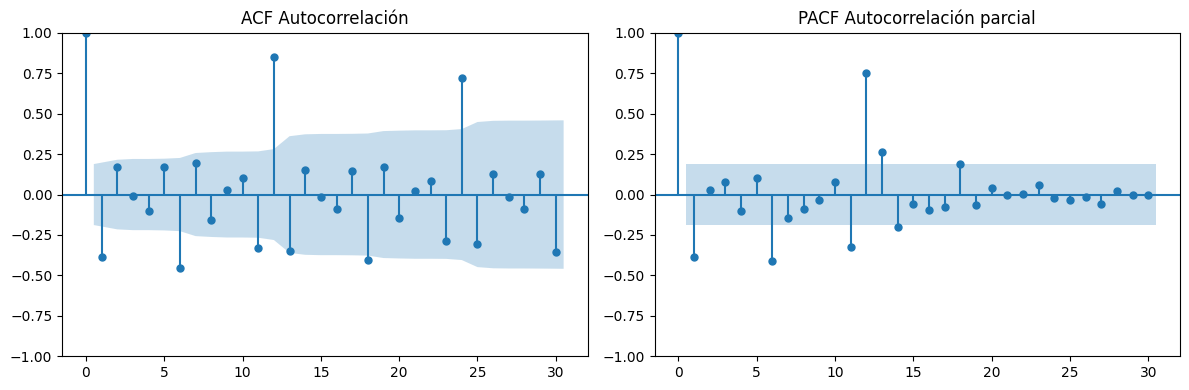

In [129]:
# Graficamos ACF y PACF
fig, axes = plt.subplots(1, 2, figsize=(12,4))

plot_acf(monthly_train, lags=30, ax=axes[0])
axes[0].set_title("ACF Autocorrelación")

plot_pacf(monthly_train, lags=30, ax=axes[1], method="ywm")
axes[1].set_title("PACF Autocorrelación parcial")

plt.tight_layout()
plt.show()

Un modelo SARIMAX se le puede incluir el mes de la semana, informacion exogena

In [130]:
# Entrenar el modelo SARIMA
sarima_model = SARIMAX(
    monthly_train,
    order=(1, 1, 1),            # (p, d, q)
    seasonal_order=(1, 1, 1, 12),  # (P, D, Q, s)
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit()

# Resumen del modelo
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        number_sold   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -872.340
Date:                            Mon, 02 Jun 2025   AIC                           1754.680
Time:                                    19:39:25   BIC                           1766.653
Sample:                                01-31-2010   HQIC                          1759.484
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1521      0.187     -0.812      0.417      -0.520       0.215
ma.L1         -0.7399      0.123   

# Solución

## 1. Limpieza

In [92]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [93]:
# Convertir la columna 'Date' a formato datetime
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [94]:
# Establecer la columna 'Date' como índice
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)

In [95]:
# Resamplear los datos a frecuencia mensual (sumando el total de ventas por mes)
monthly_train = train['number_sold'].resample('ME').sum()
monthly_test = test['number_sold'].resample('ME').sum()

## EDA

In [96]:
monthly_train.isna().mean()

np.float64(0.0)

In [97]:
monthly_train.duplicated().sum()

np.int64(1)

In [98]:
monthly_train.index.value_counts().sort_values()

Date
2010-01-31    1
2010-04-30    1
2010-05-31    1
2010-06-30    1
2010-07-31    1
             ..
2018-11-30    1
2016-12-31    1
2016-11-30    1
2018-02-28    1
2018-12-31    1
Name: count, Length: 108, dtype: int64

In [99]:
# Verificar si hay periodos faltantes (mensuales) en el set de entrenamiento
all_months = pd.date_range(start=monthly_train.index.min(), 
                           end=monthly_train.index.max(), 
                           freq='ME')
missing_months = all_months.difference(monthly_train.index)

if missing_months.empty:
    print("✅ No hay periodos mensuales faltantes en el set de entrenamiento.")
else:
    print("⚠️ Hay periodos faltantes:")
    print(missing_months)

✅ No hay periodos mensuales faltantes en el set de entrenamiento.


In [100]:
# Verificar si hay periodos faltantes (mensuales) en el set de entrenamiento
all_months = pd.date_range(start=monthly_test.index.min(), 
                           end=monthly_test.index.max(), 
                           freq='ME')
missing_months = all_months.difference(monthly_test.index)

if missing_months.empty:
    print("✅ No hay periodos mensuales faltantes en el set de test.")
else:
    print("⚠️ Hay periodos faltantes:")
    print(missing_months)

✅ No hay periodos mensuales faltantes en el set de test.


<Axes: xlabel='Date'>

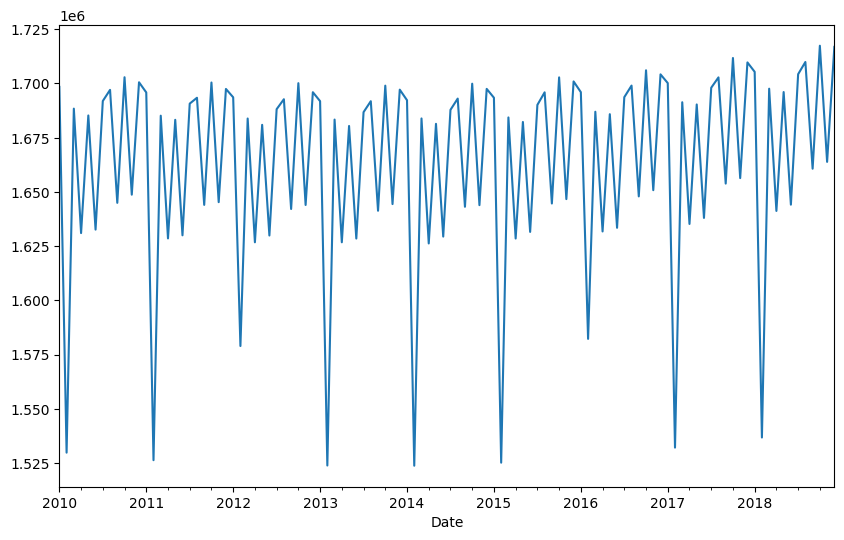

In [101]:
monthly_train.plot(figsize=(10,6))

<Axes: xlabel='Date'>

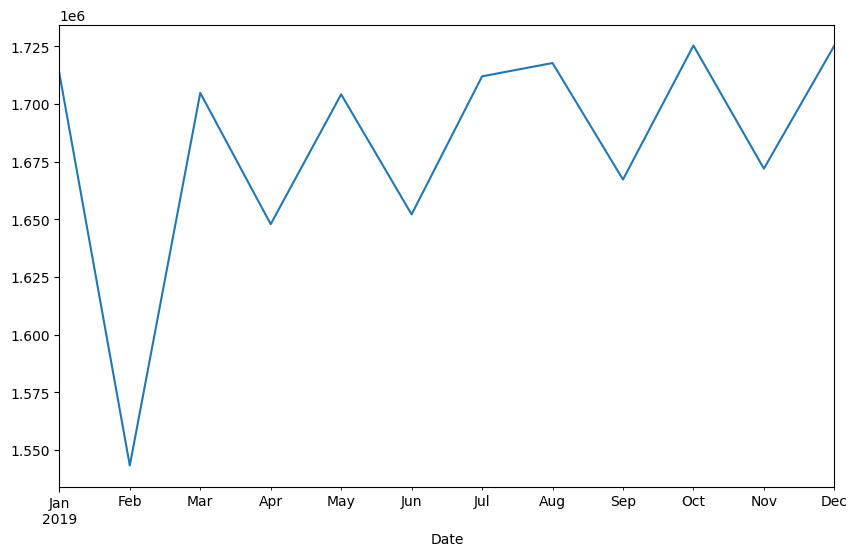

In [102]:
monthly_test.plot(figsize=(10,6))

## Statistical modeling

<Figure size 1200x800 with 0 Axes>

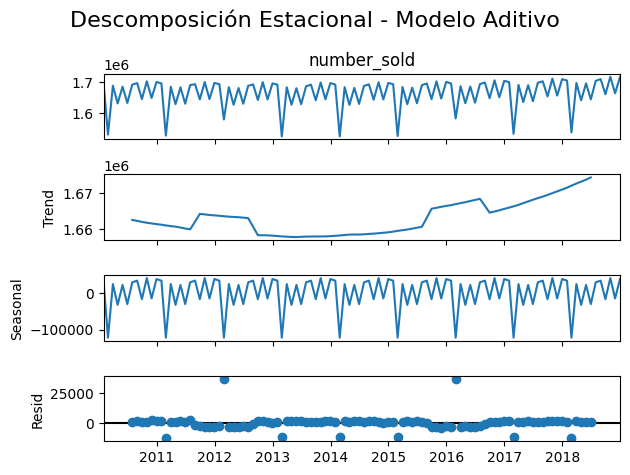

In [103]:
# Aplicar descomposición estacional (asumiendo una frecuencia mensual)
decomposition = seasonal_decompose(monthly_train, model='additive', period=12)
# Graficar los componentes
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Descomposición Estacional - Modelo Aditivo', fontsize=16)
plt.tight_layout()
plt.show()

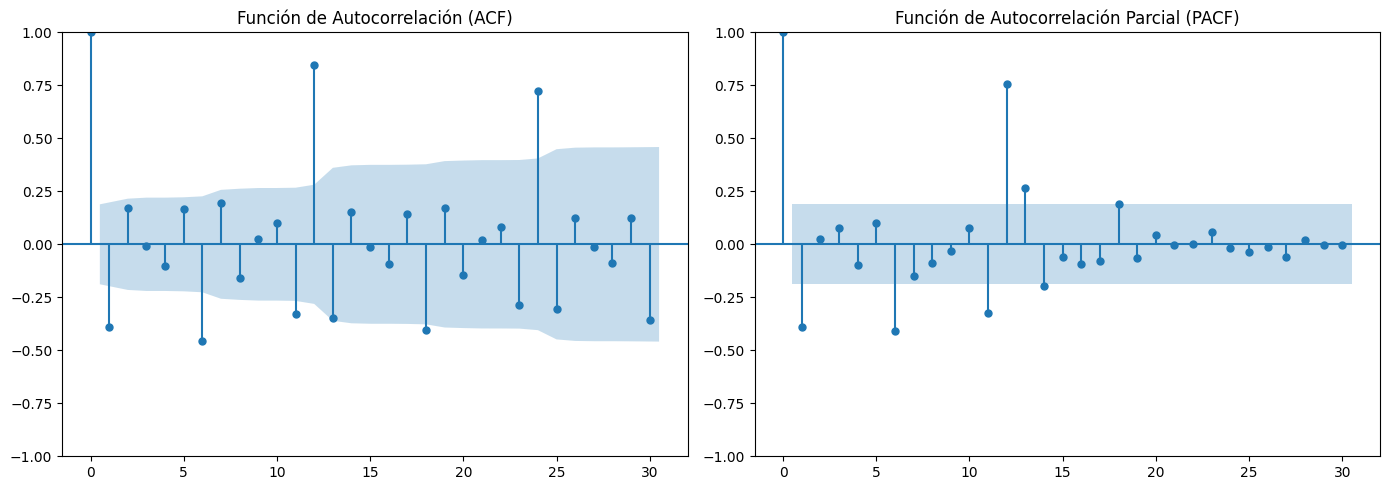

In [104]:
# Graficar ACF y PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF (Autocorrelation Function)
plot_acf(monthly_train, lags=30, ax=axes[0])
axes[0].set_title('Función de Autocorrelación (ACF)')

# PACF (Partial Autocorrelation Function)
plot_pacf(monthly_train, lags=30, ax=axes[1], method='ywm')  # 'ywm' es estable

axes[1].set_title('Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

In [105]:
# Entrenar el modelo SARIMA
sarima_model = SARIMAX(
    monthly_train,
    order=(1, 1, 1),            # (p, d, q)
    seasonal_order=(1, 1, 1, 12),  # (P, D, Q, s)
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit()

# Resumen del modelo
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        number_sold   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -872.340
Date:                            Mon, 02 Jun 2025   AIC                           1754.680
Time:                                    19:03:07   BIC                           1766.653
Sample:                                01-31-2010   HQIC                          1759.484
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1521      0.187     -0.812      0.417      -0.520       0.215
ma.L1         -0.7399      0.123   

MAPE en el set de train (sklearn): 4.25%


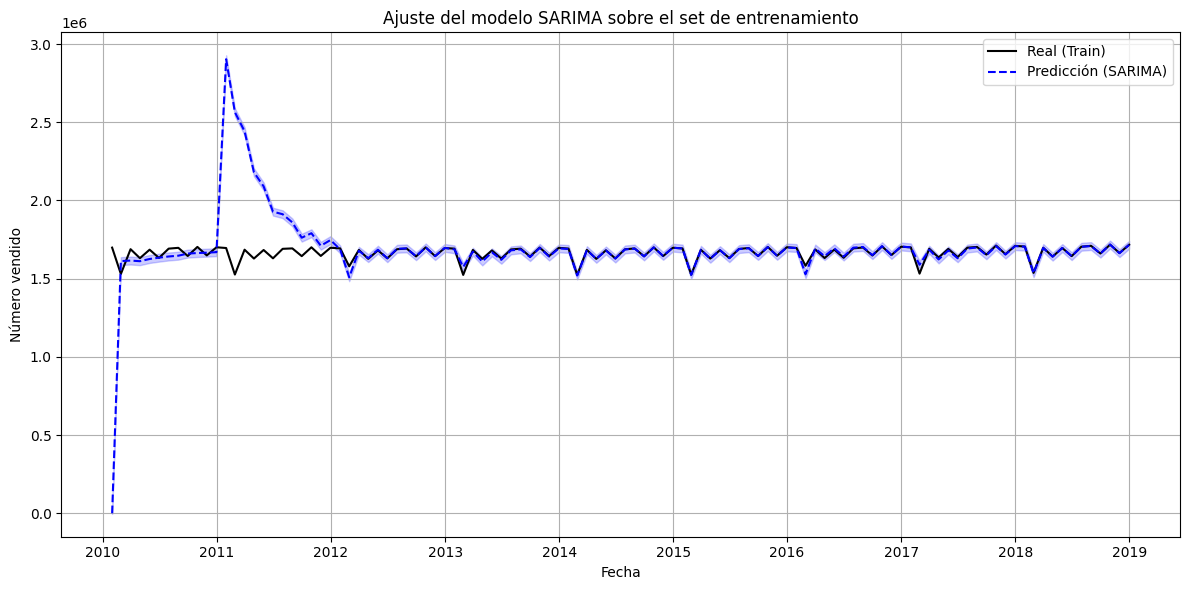

In [106]:
# Obtener predicciones dentro del rango de entrenamiento
train_pred = sarima_result.get_prediction(start=monthly_train.index[0], end=monthly_train.index[-1])
pred_mean = train_pred.predicted_mean
conf_int = train_pred.conf_int()

mape_train_sklearn = mean_absolute_percentage_error(monthly_train, pred_mean) * 100
print(f'MAPE en el set de train (sklearn): {mape_train_sklearn:.2f}%')

# Graficar valores reales vs predicciones
plt.figure(figsize=(12, 6))
plt.plot(monthly_train, label='Real (Train)', color='black')
plt.plot(pred_mean, label='Predicción (SARIMA)', color='blue', linestyle='--')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='blue', alpha=0.2)

plt.title('Ajuste del modelo SARIMA sobre el set de entrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Número vendido')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


MAPE en el set de test (sklearn): 0.06%


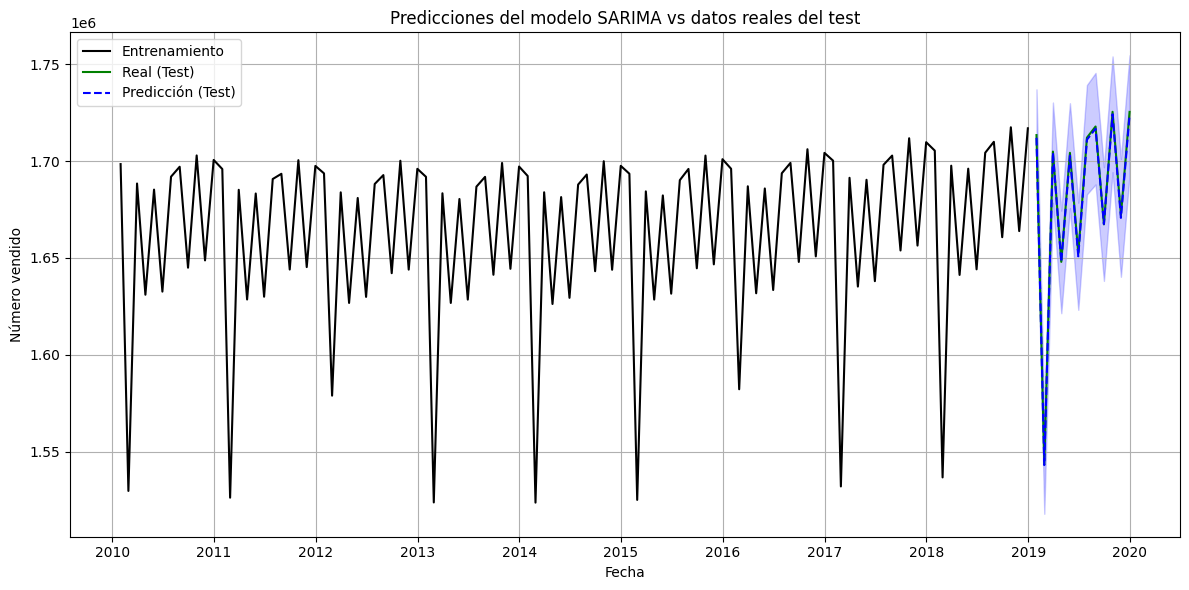

In [107]:
# Hacer predicciones para el periodo del test
n_periods = len(monthly_test)
start = monthly_test.index[0]
end = monthly_test.index[-1]

forecast = sarima_result.get_prediction(start=start, end=end)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

mape_test_sklearn = mean_absolute_percentage_error(monthly_test, forecast_mean) * 100
print(f'MAPE en el set de test (sklearn): {mape_test_sklearn:.2f}%')

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(monthly_train, label='Entrenamiento', color='black')
plt.plot(monthly_test, label='Real (Test)', color='green')
plt.plot(forecast_mean, label='Predicción (Test)', color='blue', linestyle='--')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='blue', alpha=0.2)

plt.title('Predicciones del modelo SARIMA vs datos reales del test')
plt.xlabel('Fecha')
plt.ylabel('Número vendido')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Supervised modeling

In [108]:
def create_time_features(df, max_date , target_col='number_sold', lags=[1, 3, 6, 12]):
    """
    Genera features para regresión a partir de una serie temporal.

    Parámetros:
    - df: DataFrame con columnas 'Date' y una columna objetivo (por defecto: 'number_sold')
    - target_col: nombre de la columna objetivo
    - lags: lista de valores enteros indicando los lags a generar

    Retorna:
    - DataFrame con features listas para regresión
    """
    df = df.copy().reset_index()
    
    # Asegurar que la columna de fecha esté en formato datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    
    # Crear lags
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
        df[f'mean_lag_{lag}'] = df[target_col].rolling(window=lag).mean()
        df[f'sum_lag_{lag}'] = df[target_col].rolling(window=lag).sum()
    
    # Crear features temporales
    df['month'] = df['Date'].dt.month
    df['quarter'] = df['Date'].dt.quarter
    df['semester'] = df['Date'].dt.month.map(lambda x: 1 if x <= 6 else 2)

    # Eliminar las filas con NaNs producidos por los lags
    df = df.set_index('Date')
    df = df[:max_date]
    
    return df


df_train_features = create_time_features(monthly_train, '2018-11-30' , target_col='number_sold')
df_test_features = create_time_features(monthly_test, '2019-11-30', target_col='number_sold')
df_train_features.head()

,number_sold,lag_1,mean_lag_1,sum_lag_1,lag_3,mean_lag_3,sum_lag_3,lag_6,mean_lag_6,sum_lag_6,lag_12,mean_lag_12,sum_lag_12,month,quarter,semester
Date,,,,,,,,,,,,,,,,
2010-01-31,1698403,NaN,1698403.0,1698403.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1
2010-02-28,1529750,1698403.0,1529750.0,1529750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1
2010-03-31,1688388,1529750.0,1688388.0,1688388.0,NaN,1.638847e+06,4916541.0,NaN,NaN,NaN,NaN,NaN,NaN,3,1,1
2010-04-30,1630998,1688388.0,1630998.0,1630998.0,1698403.0,1.616379e+06,4849136.0,NaN,NaN,NaN,NaN,NaN,NaN,4,2,1
2010-05-31,1685240,1630998.0,1685240.0,1685240.0,1529750.0,1.668209e+06,5004626.0,NaN,NaN,NaN,NaN,NaN,NaN,5,2,1


In [109]:
target_train = monthly_train.shift(-1)[:'2018-11-30']
df_train_features = df_train_features.drop('number_sold',axis=1)

target_test = monthly_test.shift(-1)[:'2019-11-30']
df_test_features = df_test_features.drop('number_sold',axis=1)

In [110]:
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 500],          # número de árboles
    'max_depth': [10, 20],         # profundidad máxima de los árboles
    'min_samples_leaf': [0.05, 0.1],           # mínimo número de muestras en una hoja
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                 # validación cruzada 5 folds
    n_jobs=-1,            # usar todos los cores disponibles
    scoring='neg_mean_squared_error'  # métrica para evaluar (error cuadrático negativo)
)

# Entrenar con GridSearch
grid_search.fit(df_train_features, target_train)

# Mejor modelo e hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 0.05, 'n_estimators': 100}


MAPE en el set de test (sklearn): 1.58%


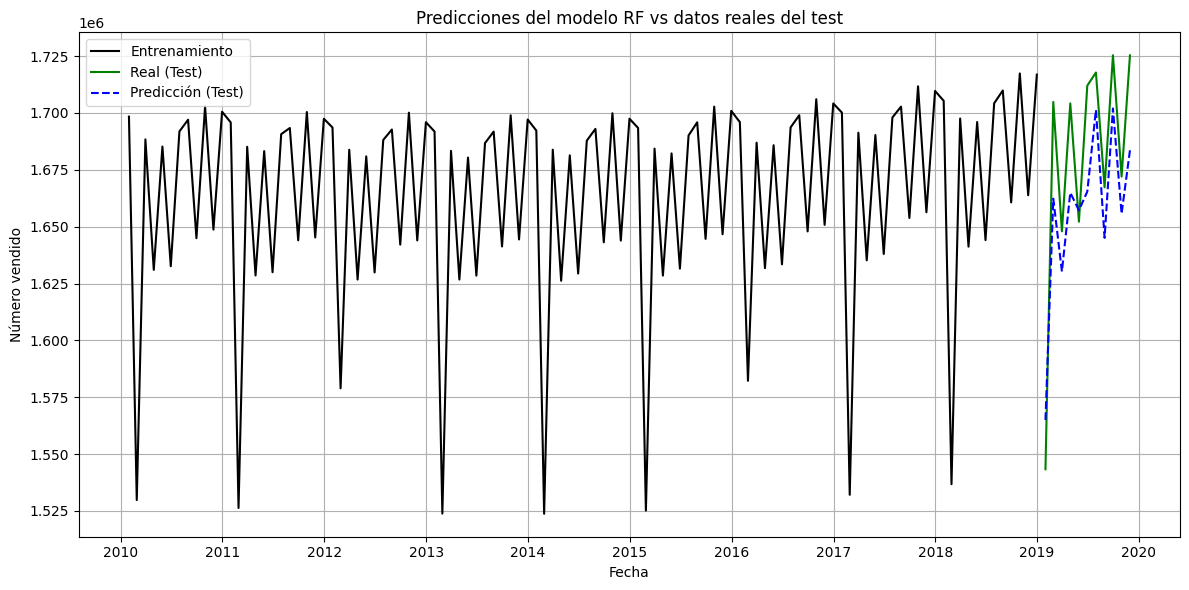

In [111]:
# Evaluar en el conjunto de prueba
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(df_test_features)
y_pred = pd.Series(y_pred,index=target_test.index)
mape = mean_absolute_percentage_error(target_test, y_pred) *100
print(f'MAPE en el set de test (sklearn): {mape:.2f}%')

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(monthly_train, label='Entrenamiento', color='black')
plt.plot(target_test, label='Real (Test)', color='green')
plt.plot(y_pred, label='Predicción (Test)', color='blue', linestyle='--')

plt.title('Predicciones del modelo RF vs datos reales del test')
plt.xlabel('Fecha')
plt.ylabel('Número vendido')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
